In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import datasets, layers, models, preprocessing
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import numpy as np
import os
from tqdm import tqdm

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# project parameters
IMAGE_SIZE = 256
EPOCHS = 15
BATCH_SIZE = 32
ROOT = "../input/bee-vs-wasp/kaggle_bee_vs_wasp/"

## Image processing

First, I will load the images, resize the image and normalize them. Then, I will split the dataset into two sets, the training and test set.  

In [4]:
df = pd.read_csv(ROOT+"labels.csv")
df.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1\10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1\10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1\10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1\1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1\10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [5]:
# # we only keep photo with a quality equals to 1
# df = df.query('photo_quality == 1').reset_index(drop=True)
# df.head()

In [6]:
# change \ in path to /
for idx in tqdm(df.index):
    df.loc[idx,'path']=df.loc[idx,'path'].replace('\\', '/')

df.head()

100%|██████████| 11421/11421 [00:08<00:00, 1279.04it/s]


,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1/10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1/10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1/10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1/1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1/10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [7]:
# number of image in every labels
number_per_label = df['label'].value_counts()
print(number_per_label)

wasp      4943
bee       3183
insect    2439
other      856
Name: label, dtype: int64


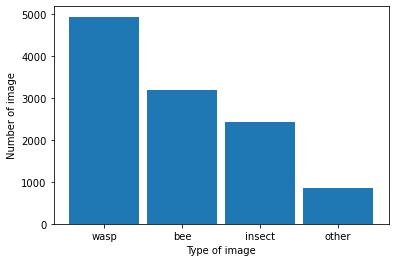

In [8]:
plt.hist(list(number_per_label.index), bins=[k for k in range(len(number_per_label.values)+1)],weights=number_per_label.values, rwidth=0.9, align='left')
plt.xlabel('Type of image')
plt.ylabel('Number of image')
plt.show()

The dataset already includes the training data, validation data and final validation data.

Below, I split the dataframe regarding those properties.

In [9]:
train_df = df.query('is_validation == 0 & is_final_validation == 0').reset_index(drop=True)
val_df = df.query('is_validation == 1').reset_index(drop=True)
test_df = df.query('is_final_validation == 1').reset_index(drop=True)

In [10]:
print("Taining set : \n",train_df['label'].value_counts())
print("\nValidation set : \n",val_df['label'].value_counts())
print("\nFinal validation set : \n",test_df['label'].value_counts())

Taining set : 
 wasp      3440
bee       2195
insect    1706
other      598
Name: label, dtype: int64

Validation set : 
 wasp      750
bee       484
insect    357
other     128
Name: label, dtype: int64

Final validation set : 
 wasp      753
bee       504
insect    376
other     130
Name: label, dtype: int64


Our datasets are not balanced, there are way more wasp images than 'other' images. 
In a first attempt, we will consider the dataset balanced. 

Let's plot some images

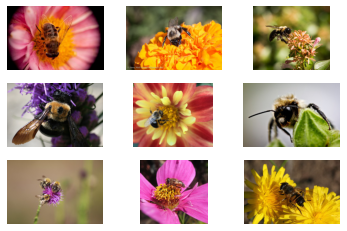

In [11]:
# let's see some bee images
plt.figure()
for i in range(1,10):
    im = Image.open(ROOT + df.query('label=="bee"')['path'].reset_index(drop=True)[i-1],mode="r")
    im = np.array(im)/255
    plt.subplot(3,3,3*(i//3)+i%3)
    plt.axis('off')
    plt.imshow(im)

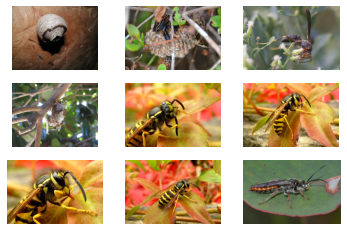

In [12]:
# let's see some wasp images
plt.figure()
for i in range(1,10):
    im = Image.open(ROOT + df.query('label=="wasp"')['path'].reset_index(drop=True)[i-1],mode="r")
    im = np.array(im)
    plt.subplot(3,3,3*(i//3)+i%3)
    plt.axis('off')
    plt.imshow(im)

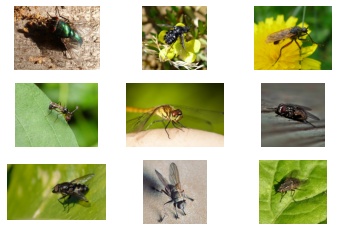

In [13]:
# let's see some other insect images
try:
    plt.figure()
    for i in range(1,10):
        im = Image.open(ROOT + df.query('label=="insect"')['path'].reset_index(drop=True)[i-1],mode="r")
        im = np.array(im)
        plt.subplot(3,3,3*(i//3)+i%3)
        plt.axis('off')
        plt.imshow(im)
except:
    print("No image")

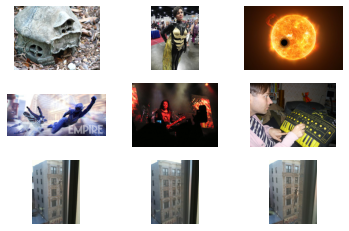

In [14]:
# let's see some other images
try :
    plt.figure()
    for i in range(1,10):
        im = Image.open(ROOT + df.query('label=="other"')['path'].reset_index(drop=True)[i-1],mode="r")
        im = np.array(im)
        plt.subplot(3,3,3*(i//3)+i%3)
        plt.axis('off')
        plt.imshow(im)
except:
    print("No image")

In order to train a machine learning algorithm on those data, I will first create the 3 datasets :
- training set
- validation set
- final validation set.


The datasets will be composed of the processed images and the labels.

In [15]:
# data loader
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
val_fin_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [16]:
train_generator = train_datagen.flow_from_dataframe(
            train_df, 
            directory=ROOT, 
            x_col='path', 
            y_col='label',
            classes=['bee','wasp','insect','other'],
            target_size=(IMAGE_SIZE, IMAGE_SIZE), 
            batch_size=BATCH_SIZE, 
            shuffle=True, 
            seed=123
        )
validation_generator = val_datagen.flow_from_dataframe(
            val_df, 
            directory=ROOT, 
            x_col='path', 
            y_col='label',
            classes=['bee','wasp','insect','other'],
            target_size=(IMAGE_SIZE, IMAGE_SIZE), 
            batch_size=BATCH_SIZE, 
            shuffle=True, 
            seed=123
        )
validation_finale_generator = val_fin_datagen.flow_from_dataframe(
            test_df, 
            directory=ROOT, 
            x_col='path', 
            y_col='label',
            classes=['bee','wasp','insect','other'],
            target_size=(IMAGE_SIZE, IMAGE_SIZE), 
            batch_size=BATCH_SIZE, 
            shuffle=True, 
            seed=123
        )

Found 7939 validated image filenames belonging to 4 classes.
Found 1719 validated image filenames belonging to 4 classes.
Found 1763 validated image filenames belonging to 4 classes.


In [17]:
ROTATION = 0.2
ZOOM = 0.2
CONTRAST = 0.2

data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)),
    layers.experimental.preprocessing.RandomRotation(ROTATION),
    layers.experimental.preprocessing.RandomZoom(ZOOM),
    #layers.experimental.preprocessing.RandomContrast([1-CONTRAST, 1+CONTRAST])
  ]
)

In [18]:
model = models.Sequential(data_augmentation)
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
Total params: 23,584
Trainable params: 23,584
Non-trainable params: 0
__________________________________________________

In [19]:
layers.Dropout(0.2)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
layers.Dropout(0.2)
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 230400)           

In [20]:
model.compile(optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy'])

In [21]:
tf.debugging.set_log_device_placement(True)

# Place tensors on the CPU
with tf.device('/:GPU:0'):    
    history = model.fit_generator(
        train_generator, 
        steps_per_epoch=200,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=100
    )

Epoch 1/5
200/200 [==============================] - 465s 2s/step - loss: 1.1707 - accuracy: 0.5288 - val_loss: 0.9377 - val_accuracy: 0.6242
Epoch 2/5
200/200 [==============================] - 421s 2s/step - loss: 0.9528 - accuracy: 0.6128
Epoch 3/5
200/200 [==============================] - 420s 2s/step - loss: 0.8857 - accuracy: 0.6463
Epoch 4/5
200/200 [==============================] - 426s 2s/step - loss: 0.8589 - accuracy: 0.6562
Epoch 5/5
200/200 [==============================] - 436s 2s/step - loss: 0.8521 - accuracy: 0.6621


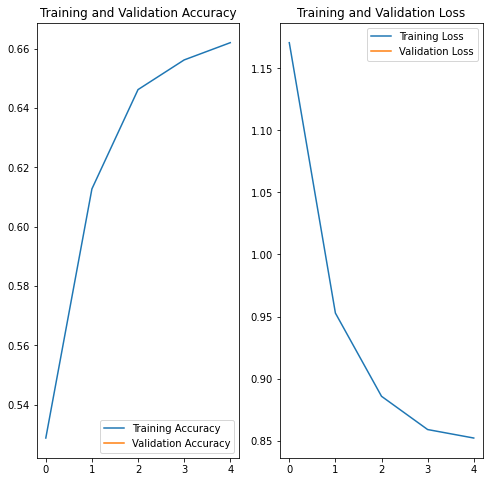

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
test_loss, test_acc = model.evaluate(validation_finale_generator, verbose=2)

56/56 - 10s - loss: 0.8201 - accuracy: 0.6909


### Confusion matrix

In [24]:
confusion_matrix = tf.math.confusion_matrix(
    validation_finale_generator.classes, np.argmax(model.predict(validation_finale_generator), axis=1)
)
print(confusion_matrix)

tf.Tensor(
[[117  88   3 296]
 [ 76  69   2 229]
 [ 28  25   2  75]
 [168 130  15 440]], shape=(4, 4), dtype=int32)


In [25]:
print(np.diag(confusion_matrix))

[117  69   2 440]


In [26]:
good_prediction = np.sum(np.diag(confusion_matrix))
wrong_prediction = np.sum(confusion_matrix) - good_prediction

print("Good prediction : ", good_prediction)
print("Wrong prediction : ", wrong_prediction)

Good prediction :  628
Wrong prediction :  1135


### AUC-ROC score and ROC-curve


## Test of this model on some images

In [27]:
def get_image(df,path,image_size=IMAGE_SIZE):
    """
    This function takes a dataframe df and returns the image with path 'path' after processing it  
    """
    idx = df['path'][df['path']==path].index.tolist()[0]
    im = np.array(Image.open(ROOT+df['path'][idx], mode='r'))/255
    label = df['label'][idx]
    try:
        im = tf.image.resize(im, (image_size,image_size), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False, antialias=False, name=None)
    except :
        # if the image is a grayscale
        im_3d = np.zeros((im.shape[0],im.shape[1],3))
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
                im_3d[i,j,:] = im[i,j]
        im = tf.image.resize(im_3d, (image_size,image_size), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False, antialias=False, name=None)
    return im, label

In [28]:
def prediction(model,df,list_path):
    """
    This functions takes the trained model and a list of paths and returns
    the list of predicted label for the images corresponding th the paths.
    It plots every images with the prediction
    """
    label = ["bee","wasp","insect","other"]
    plt.figure()
    images = []
    list_true = []
    list_prediction = []
    for path in list_path:
        im, lbl = get_image(df,path)
        images.append(im)
        list_true.append(lbl)        
    for lbl in np.argmax(model.predict(np.array(images)),axis=1):
        list_prediction.append(label[lbl])
        
    for i in range(len(list_true)):
        if i >= 9:
            break
        plt.subplot(3,3,3*((i+1)//3)+(i+1)%3)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(list_prediction[i] + " - " + list_true[i])
    
    plt.show()
        
    return list_true,list_prediction

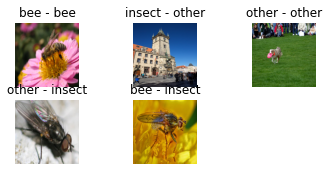

(['bee', 'other', 'other', 'insect', 'insect'],
 ['bee', 'insect', 'other', 'other', 'bee'])

In [29]:
prediction(model,df,['bee1/1240800_e5f2b40032_n.jpg',
                     'other_noinsect/521021.jpg',
                     'other_noinsect/521697.jpg',
                     'other_insect/5826066_3071dcf48f_n.jpg',
                     'other_insect/7091961939_f90294ee2e_w.jpg'
                    ]
          )

## Conclusion of the CNN

Accuracy : 80%
